## Machine learning modeling - Iteration #5


In [100]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import resample

In [101]:
# read in 990 data that has been
# with features already adjusted in 2nd iteration
df = pd.read_csv('data/990_model_data_3.csv')

In [102]:
df.shape

(26881, 28)

In [103]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792.0,11,11,37,0.0,0.0,0.0,0.0,39372255.0,26541056.0,12831199.0,0.0,39367859.0,26785093.0,12582766.0,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036.0,9,8,81,8.0,52565.0,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299.0,188534687.0,170915216.0,17619471.0,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978.0,21,19,53,200.0,16110.0,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972.0,3640881.0,852359.0,2788522.0,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298.0,8,7,442,15.0,0.0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630.0,56726534.0,12198910.0,44527624.0,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176.0,12,12,139,50.0,2437.0,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724.0,10535130.0,3089889.0,7445241.0,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


## Up-sample minority class to see if this improves model performance  

In [104]:
df_majority_class = df[df.TARGET_FEATURE == False]

In [105]:
# how many records are in the majority class?
df_majority_class.shape

(23972, 28)

In [106]:
df_minority_class = df[df.TARGET_FEATURE == True]

In [107]:
df_minority_class.shape

(2909, 28)

In [108]:
# upsample minority class
df_minority_upsampled = resample(df_minority_class,
                                replace=True,
                                n_samples=23972)

In [109]:
df_upsampled = pd.concat([df_majority_class, df_minority_upsampled])

In [110]:
# verify that I have the same number of records of each class
df_upsampled.TARGET_FEATURE.value_counts()

True     23972
False    23972
Name: TARGET_FEATURE, dtype: int64

In [111]:
# assign features
X = pd.get_dummies(df_upsampled).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df_upsampled.TARGET_FEATURE

In [112]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [113]:
# create model, check for overfitting
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=8)

cross_val_score(rfc, X, y, cv=5)

array([0.7561001 , 0.73451512, 0.71756362, 0.74457655, 0.74103045])

In [114]:
rfc.fit(X_train, y_train)

predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.08204927649589362
Percent Type II errors: 0.1644896362925303

Test set accuracy:
Percent Type I errors: 0.08687037230159558
Percent Type II errors: 0.17155073521743663


In [115]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,16019,3147
Actual: Yes,6309,12880


In [116]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,3973,833
Actual: Yes,1645,3138


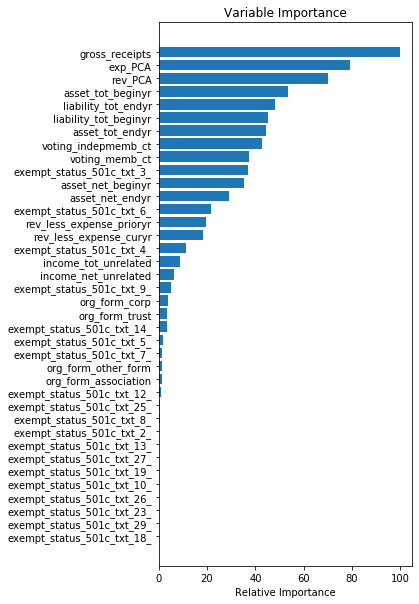

In [117]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');


### KNN Classifier

In [118]:
# fit model based on optimized parameters
knn_clf = KNeighborsClassifier(leaf_size= 1, n_neighbors= 110)

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [119]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [120]:
predict_train = knn_clf.predict(X_train)
predict_test = knn_clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.11500456263850867
Percent Type II errors: 0.18041976274279756

Test set accuracy:
Percent Type I errors: 0.11982479924913964
Percent Type II errors: 0.18302221295234122


In [121]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,14755,4411
Actual: Yes,6920,12269


In [122]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,3657,1149
Actual: Yes,1755,3028


### Gradient Boost Classifier

In [123]:
# Initialize and fit the model.
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
cross_val_score(clf, X2, y, cv=5)

array([0.87914494, 0.86006257, 0.85054234, 0.8730705 , 0.86869003])

In [124]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.09013166471125016
Percent Type II errors: 0.11044192412983965

Test set accuracy:
Percent Type I errors: 0.10053185942225466
Percent Type II errors: 0.11940765460423401


In [125]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,15709,3457
Actual: Yes,4236,14953


In [126]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,3842,964
Actual: Yes,1145,3638


xxx

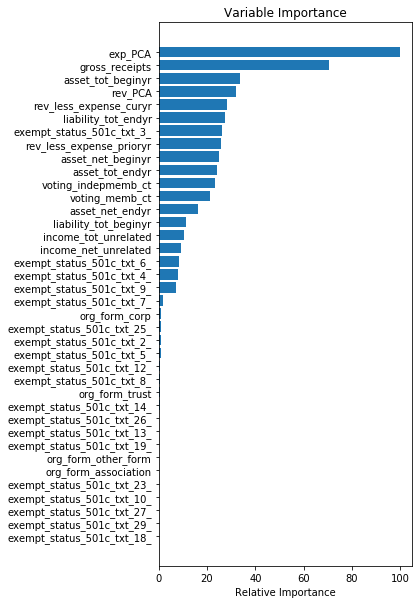

In [127]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [128]:
# find 10 most significant features
clf_features = pd.DataFrame(clf.feature_importances_,
            X.columns, columns=['importance']).sort_values(by='importance', ascending=False)

list(clf_features.head(10).index)

['exp_PCA',
 'gross_receipts',
 'asset_tot_beginyr',
 'rev_PCA',
 'rev_less_expense_curyr',
 'liability_tot_endyr',
 'exempt_status_501c_txt_3_',
 'rev_less_expense_prioryr',
 'asset_net_beginyr',
 'asset_tot_endyr']

### SVC

In [129]:
svc = SVC(gamma='scale', C= 1, class_weight=  'balanced', verbose=True)

svc.fit(X_train, y_train)

[LibSVM]

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [130]:
predict_train = svc.predict(X_train)
predict_test = svc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.2811888932342589
Percent Type II errors: 0.11302307391474384

Test set accuracy:
Percent Type I errors: 0.27927833976431327
Percent Type II errors: 0.11054333089998958


In [131]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,8381,10785
Actual: Yes,4335,14854


In [132]:
# testing results

pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,2128,2678
Actual: Yes,1060,3723
